In [2]:
import matplotlib
# matplotlib.use('Agg')
import os, sys
import yaml
from argparse import ArgumentParser
from tqdm import tqdm

import imageio
import numpy as np
from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback

from modules.generator import OcclusionAwareGenerator
from modules.keypoint_detector import KPDetector
from animate import normalize_kp
from scipy.spatial import ConvexHull
from detect_mtcnn import face_detetect
import cv2
from matplotlib import pyplot as plt 
import matplotlib.gridspec as gridspec


Running on device: cuda:0


In [3]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    gs = gridspec.GridSpec(nRows, nCols)     
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,20))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')

        plt.subplot(nRows, nCols,i+1)

        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')

    plt.show()

In [4]:
if sys.version_info[0] < 3:
    raise Exception("You must use Python 3 or higher. Recommended version is Python 3.7")

def load_checkpoints(config_path, checkpoint_path, cpu=False):

    with open(config_path) as f:
        config = yaml.load(f)

    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
    if not cpu:
        generator.cuda()

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])
    if not cpu:
        kp_detector.cuda()
    
    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
 
    generator.load_state_dict(checkpoint['generator'])
    kp_detector.load_state_dict(checkpoint['kp_detector'])
    
    if not cpu:
        generator = DataParallelWithCallback(generator)
        kp_detector = DataParallelWithCallback(kp_detector)

    generator.eval()
    kp_detector.eval()
    
    return generator, kp_detector


def make_animation(source_image, driving_video, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=False):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        kp_source = kp_detector(source)
        kp_driving_initial = kp_detector(driving[:, :, 0])

        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            kp_driving = kp_detector(driving_frame)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                   use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
    return predictions

In [5]:
def find_best_frame(source, driving, cpu=False):
    import face_alignment

    def normalize_kp(kp):
        kp = kp - kp.mean(axis=0, keepdims=True)
        area = ConvexHull(kp[:, :2]).volume
        area = np.sqrt(area)
        kp[:, :2] = kp[:, :2] / area
        return kp

    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True,
                                      device='cpu' if cpu else 'cuda')
    kp_source = fa.get_landmarks(255 * source)[0]
    kp_source = normalize_kp(kp_source)
    norm  = float('inf')
    frame_num = 0
    for i, image in tqdm(enumerate(driving)):
        kp_driving = fa.get_landmarks(255 * image)[0]
        kp_driving = normalize_kp(kp_driving)
        new_norm = (np.abs(kp_source - kp_driving) ** 2).sum()
        if new_norm < norm:
            norm = new_norm
            frame_num = i
    return frame_num

In [6]:
def erosion(image, kernel_size, iterations=1):
    kernel = np.ones((kernel_size,kernel_size), np.uint8)  
    img_erosion = cv2.erode(image, kernel, iterations=1)
    return img_erosion

def dilation(image, kernel_size, iterations=1):
    kernel = np.ones((kernel_size,kernel_size), np.uint8)  
    img_dilation = cv2.dilate(image, kernel, iterations=1)
    return img_dilation

def resize_prediction(prediction,t,b,l,r):
    predict = (prediction.copy()*255).astype("uint8")
    resized_res = cv2.resize(predict,(r-l,b-t))
    return resized_res

def blend_image(face_result, full_result, t,b,l,r):
    face_result_f = (face_result.astype("float32"))/255
    full_result_f = (full_result.astype("float32"))/255
    
    fore_grd_f = np.zeros_like(full_result_f)
    fore_grd_f[t:b,l:r] = face_result_f
    back_grd_f = full_result_f.copy()

    small_mask_f = np.ones_like(face_result_f)
    mask_f = np.zeros_like(full_result_f)
    mask_f[t:b, l:r] = small_mask_f
    mask_f = erosion(mask_f, 35, 2)
    mask_f = cv2.GaussianBlur(mask_f, (29,29), 0)
    mask_f = cv2.GaussianBlur(mask_f, (35,35), 0)
    
    fore_grd_f = cv2.multiply(mask_f, fore_grd_f)
    back_grd_f = cv2.multiply(np.ones_like(mask_f) - mask_f, back_grd_f)
    added_result = cv2.add(fore_grd_f, back_grd_f)
    added_result = (added_result*255).astype("uint8")
    return added_result

def post_process(src_image, prediction,t,b,l,r):
    resize_face = resize_prediction(prediction, t,b,l,r)
    result = blend_image(resize_face, src_image, t,b,l,r)
    return result

In [7]:
class OPT:
    def __init__(self):
        self.config = "config/vox-adv-256.yaml"
        self.checkpoint = "pretrain_model/vox-adv-cpk.pth.tar"
        self.source_image = "data/image/14.jpg"
        self.driving_video  ="data/video/test_18.mp4"
        self.result_video = "data/res_reen/14_test_18.mp4"
        self.relative = True
        self.adapt_scale = False
        self.find_best_frame = False
        self.best_frame = None
        self.cpu = False
        
opt = OPT()

data/image/14.jpg


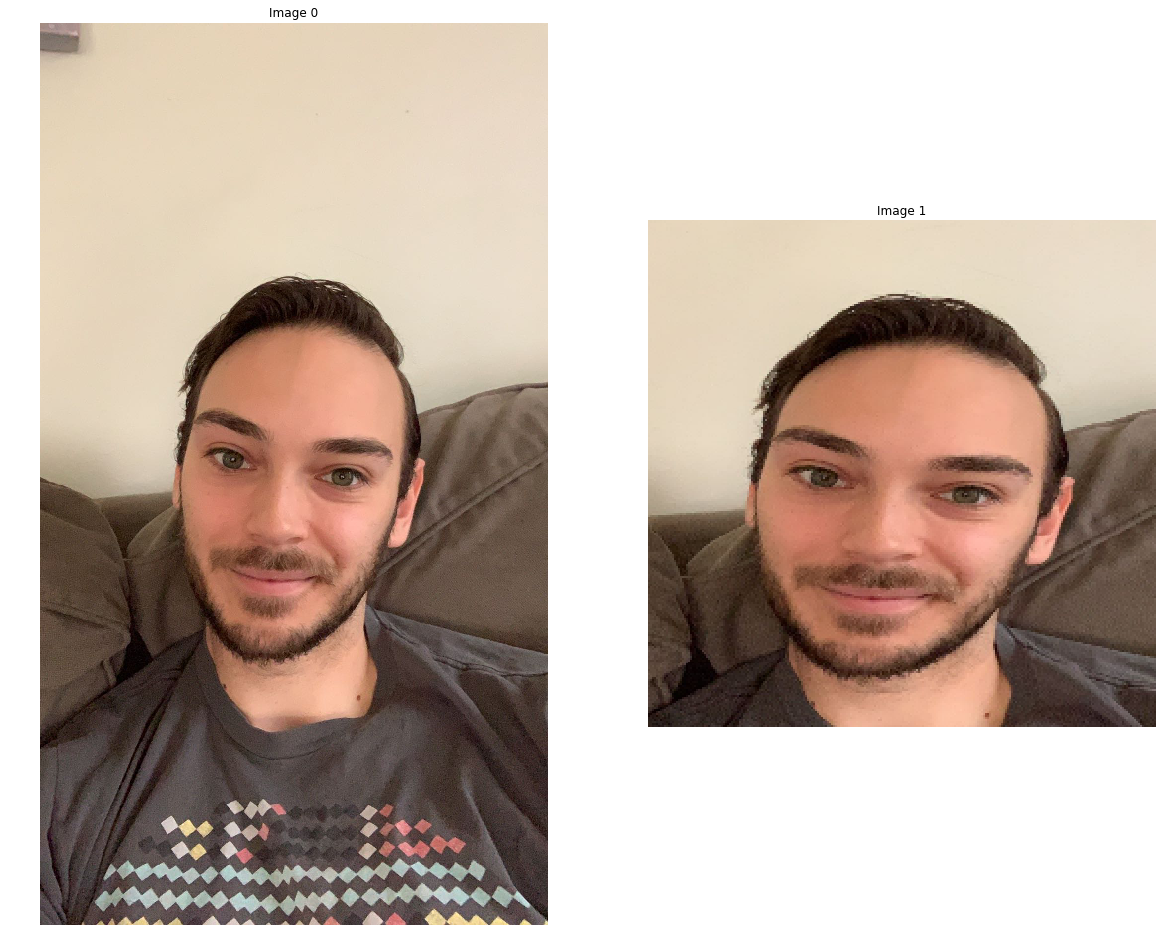

116 360 903 1386
(256, 256, 3)


In [8]:
from PIL import Image
print(opt.source_image)
image = imageio.imread(opt.source_image)

img_pil = Image.fromarray(image)
aligned_img_pil,l,t,r,b = face_detetect(img_pil,scale=1.25)  #Pil Image, Aligned face
aligned_img = np.array(aligned_img_pil)
ShowImage([image, aligned_img], 1, 2)
print(l,t,r,b)
print(aligned_img.shape)

In [9]:
# source_image = imageio.imread(opt.source_image)
source_image = aligned_img.copy()
reader = imageio.get_reader(opt.driving_video)
fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
generator, kp_detector = load_checkpoints(config_path=opt.config, checkpoint_path=opt.checkpoint, cpu=opt.cpu)

if opt.find_best_frame or opt.best_frame is not None:
    import pdb; pdb.set_trace()
    i = opt.best_frame if opt.best_frame is not None else find_best_frame(source_image, driving_video, cpu=opt.cpu)
    print ("Best frame: " + str(i))
    driving_forward = driving_video[i:]
    driving_backward = driving_video[:(i+1)][::-1]
    predictions_forward = make_animation(source_image, driving_forward, generator, kp_detector, relative=opt.relative, adapt_movement_scale=opt.adapt_scale, cpu=opt.cpu)
    predictions_backward = make_animation(source_image, driving_backward, generator, kp_detector, relative=opt.relative, adapt_movement_scale=opt.adapt_scale, cpu=opt.cpu)
    predictions = predictions_backward[::-1] + predictions_forward[1:]
else:
    predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=opt.relative, adapt_movement_scale=opt.adapt_scale, cpu=opt.cpu)
post_predictions = [post_process(image, prediction,t,b,l,r) for prediction in predictions]
# imageio.mimsave(opt.result_video, [img_as_ubyte(frame) for frame in post_predictions], fps=fps)


/home/nhattruong/anaconda3/envs/venv_firstorder2/lib/python3.7/site-packages/imageio/core/format.py:403: UserWarning: Could not read last frame of /home/nhattruong/Project/first-order-model/data/video/test_18.mp4.
  warn('Could not read last frame of %s.' % uri)
/home/nhattruong/anaconda3/envs/venv_firstorder2/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nhattruong/anaconda3/envs/venv_firstorder2/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/nhattruong/anaconda3/envs/venv_firstorder2/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is 

In [10]:
imageio.mimsave(opt.result_video, [img_as_ubyte(frame) for frame in post_predictions], fps=fps)

In [ ]:
ShowImage([image, aligned_img, predictions[10]], 1, 3)

In [ ]:
prediction = predictions[10]

res = post_process(image, prediction,t,b,l,r)
ShowImage([aligned_img, prediction], 1, 2)
ShowImage([image, res], 1, 2)